In [1]:
import collections
import functools
import itertools
import os
import time

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize

import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format='retina'
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath,amssymb}',
})

import dclf

from tqdm.auto import tqdm

tracker = dclf.ParamTracker()
param = tracker.store

## Read data and select learners

In [2]:
lcdb_df = pd.read_csv(os.path.expanduser('~/Documents/data/delegated_classification/lcdb/database/database-accuracy.csv'))
lcdb_df.head()

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
0,44,SVC_linear,16,461,0,0,0.0024,0.8750,0.7440,0.7072
1,44,SVC_linear,23,461,0,0,0.0014,0.9565,0.7222,0.6876
2,44,SVC_linear,32,461,0,0,0.0017,0.9375,0.7295,0.7180
3,44,SVC_linear,45,461,0,0,0.0023,0.9778,0.8237,0.8048
4,44,SVC_linear,64,461,0,0,0.0033,0.7812,0.6280,0.6508


In [3]:
selected_learners = np.array([
    'sklearn.neural_network.MLPClassifier',
    'sklearn.ensemble.GradientBoostingClassifier',
])

selected_openmlid = dclf.mnist_openmlid

In [4]:
(
    lcdb_df
    .query('openmlid==@selected_openmlid and learner in @selected_learners')
    ['size_train']
    .value_counts()
    .sort_index()
)
    

16       30
23       30
32       30
45       30
64       30
91       30
128      30
181      30
256      30
362      30
512      30
724      30
1024     30
1448     30
2048     30
2896     30
4096     30
5793     30
8192     30
11585    30
16384    30
23170    30
32768    29
60000    25
Name: size_train, dtype: int64

## Select learners

[None,
 Text(0.5, 0, 'Training set size $n$'),
 Text(0, 0.5, 'Test-set accuracy $\\mathrm{acc}(n)$'),
 Text(0.5, 1.0, 'MNIST learning curves')]

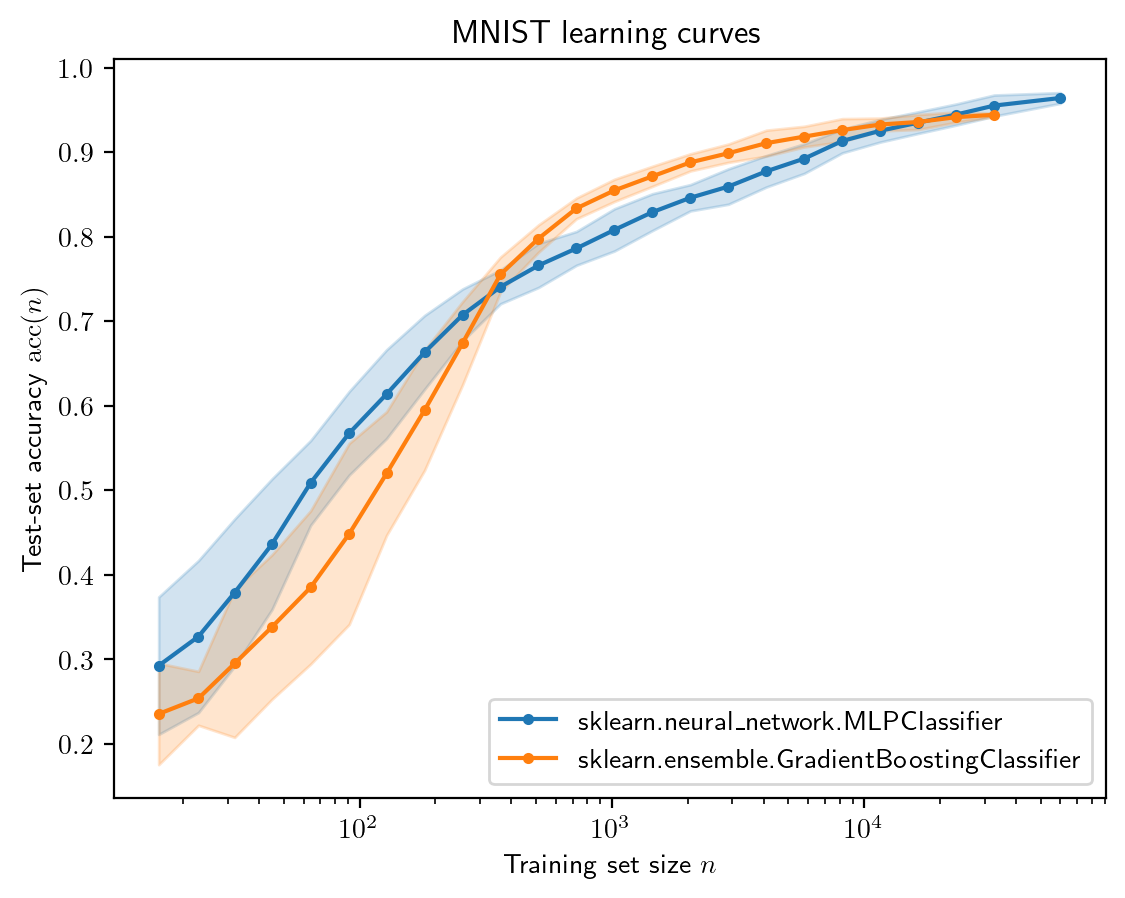

In [5]:
fig,ax=plt.subplots()
plot_learning_curve = lambda learner, ax: (
    lcdb_df
    .query('openmlid==@selected_openmlid and learner==@learner')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .apply(dclf.describe_series_of_samples)
    .pipe(
        dclf.df_plot_curve_with_band,
        mean='mean',
        lb='std_lb',
        ub='std_ub',
        ax=ax,
        label=learner,
        marker='.',
    )
)

for learner in selected_learners:
    plot_learning_curve(learner,ax=ax)

ax.legend()
ax.set(
    xscale='log',
    xlabel='Training set size $n$',
    ylabel='Test-set accuracy $\\mathrm{acc}(n)$',
    title=f'MNIST learning curves'
)


## Utility functions

In [6]:
closest_ind = lambda arr, val: np.argmin(np.abs(np.array(arr)-val))

build_cdp = lambda learner, m: (
    lcdb_df
    .query('openmlid==@selected_openmlid and learner==@learner')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .pipe(
        dclf.BootstrappedBinomialMixtureContractDesignProblem.from_series,
        m=m,
        ensure_zero_cost_action=True,
    )
)


## Compute grid

In [7]:

# m_vec = (np.arange(30)+1)*2
# m_vec = sorted(np.unique(np.geomspace(1,100,20,dtype=int)))
# m_vec = sorted(np.unique(np.linspace(1,50,20,dtype=int)))
m_vec = np.hstack([np.arange(1,10), np.arange(10,20,2), np.arange(20,51,4)])
param(max(m_vec),'max_m')
print('m_vec:',m_vec)

n_vec = np.array(build_cdp(learner, m=1).cost)
actions_vec = np.arange(4,len(n_vec))
print('actions:',n_vec[actions_vec])

contract_types = {
    'min_budget_lp': dclf.MinBudgetContract.design,
    # 'min_budget_local': dclf.MinBudgetLocalContract.design,
    # 'min_budget_local_eps': functools.partial(dclf.MinBudgetLocalContract.design, eps=1e-9),
    'min_budget_local': functools.partial(dclf.MinBudgetLocalContract.design, compare_to_all=False),
    # 'min_budget_threshold': functools.partial(dclf.MinBudgetStatisticalContract.design, binary_domain=True, monotone=True),
    # 'threshold_binary': dclf.BinarySearchThresholdContract.design,
}

m_results = []
for m in tqdm(m_vec):
    for learner in selected_learners:
        # orig_cdp = build_cdp(learner, m=m)
        cdp = build_cdp(learner, m=m)
        # eps = 1e-9
        # cdp.f_ij = (1-eps)*cdp.f_ij + eps*np.ones(cdp.f_ij.shape)/cdp.f_ij.shape[1]
        # cdp.f_ij[cdp.f_ij<eps] = 0
        # cdp.f_ij /= np.expand_dims(cdp.f_ij.sum(axis=1),axis=1)
        for action, contract_type in itertools.product(
            actions_vec,
            contract_types,
        ):
            # if 'local' not in contract_type and m>30:
            #     continue
            try:
                contract = contract_types[contract_type](
                    cdp,
                    target_action=action,
                )
            except (RuntimeError, ZeroDivisionError):
                continue
            if contract['t'][0]==None:
                continue
            response = dclf.get_agent_response(
                cdp,
                contract['t'],
            )
            if not response.selected_action>=action:
                # raise RuntimeError
                continue
            m_results.append({
                'm': m,
                'contract_type': contract_type,
                'learner': learner,
                'action': action,
                'n': cdp.cost[action],
                'n_acc': cdp.mean_acc[action],
                'B':contract['t'].max(),
                'selected_action_utility':response.selected_action_utility,
                'selected_action_cost':response.selected_action_cost,
                'expected_pay':response.expected_pay,
                'cdp':cdp,
                'contract':contract,
                'response':response,
            })
            
m_results_df = pd.DataFrame(m_results)
m_results_df.head()

m_vec: [ 1  2  3  4  5  6  7  8  9 10 12 14 16 18 20 24 28 32 36 40 44 48]
actions: [   45    64    91   128   181   256   362   512   724  1024  1448  2048
  2896  4096  5793  8192 11585 16384 23170 32768]


  0%|          | 0/22 [00:00<?, ?it/s]

,m,contract_type,learner,action,n,n_acc,B,selected_action_utility,selected_action_cost,expected_pay,cdp,contract,response
0,1,min_budget_lp,sklearn.neural_network.MLPClassifier,4,45,0.436160,226.702009,53.878348,45,98.878348,BootstrappedBinomialMixtureContractDesignProbl...,"{'primal_model': [None], 'primal_result': {'Pr...","RationalChoice(utility=array([ 0.00000000e+00,..."
1,1,min_budget_local,sklearn.neural_network.MLPClassifier,4,45,0.436160,226.702009,53.878348,45,98.878348,BootstrappedBinomialMixtureContractDesignProbl...,"{'t': [0.0, 226.70200892857142], 'budget': 226...","RationalChoice(utility=array([ 0.00000000e+00,..."
2,1,min_budget_lp,sklearn.neural_network.MLPClassifier,5,64,0.508680,261.996691,69.272477,64,133.272477,BootstrappedBinomialMixtureContractDesignProbl...,"{'primal_model': [None], 'primal_result': {'Pr...","RationalChoice(utility=array([ 0.00000000e+00,..."
3,1,min_budget_local,sklearn.neural_network.MLPClassifier,5,64,0.508680,261.996691,69.272477,64,133.272477,BootstrappedBinomialMixtureContractDesignProbl...,"{'t': [0.0, 261.9966905681184], 'budget': 261....","RationalChoice(utility=array([ 0.00000000e+00,..."
4,1,min_budget_lp,sklearn.neural_network.MLPClassifier,6,91,0.567384,459.934587,169.959526,91,260.959526,BootstrappedBinomialMixtureContractDesignProbl...,"{'primal_model': [None], 'primal_result': {'Pr...","RationalChoice(utility=array([ 0.00000000e+00,..."


## Plot results

0.8460639999999999
0.8547999999999998
Figure saved as ./output/full_information_contract_analysis.pdf


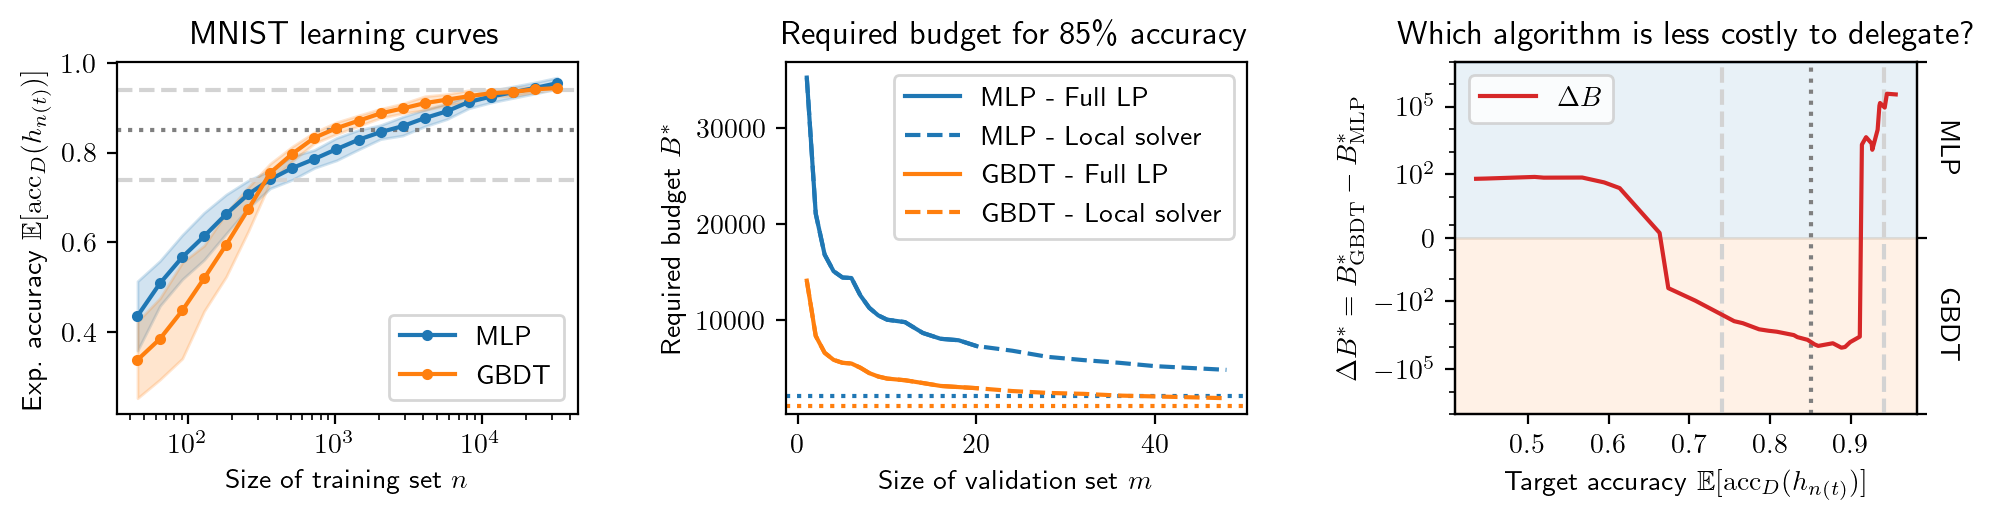

In [8]:
fig,axs=plt.subplots(1,3,figsize=(10,2.7), tight_layout={'w_pad':3})

axs_it = iter(axs.ravel())

expected_accuracy_label = 'Exp. accuracy $\mathbb{E}[\\mathrm{acc}_D(h_{n(t)})]$'
training_set_size_label = 'Size of training set $n$'

#
# Learning curves
#
ax = next(axs_it)

plot_learning_curve = lambda learner, ax: (
    lcdb_df
    .query('openmlid==@selected_openmlid and learner==@learner and size_train in @n_vec[@actions_vec]')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .apply(dclf.describe_series_of_samples)
    .pipe(
        dclf.df_plot_curve_with_band,
        mean='mean',
        lb='std_lb',
        ub='std_ub',
        ax=ax,
        label=dclf.lcdb_learner_names[learner],
        marker='.',
    )
)

for learner in selected_learners:
    plot_learning_curve(learner,ax=ax)

crossing_accs = [
    param(0.74,'crossing_point_low'),
    param(0.94,'crossing_point_high'),
]

crossing_n = [
    param(cdp.cost[closest_ind(cdp.mean_acc,crossing_accs[0])], 'crossing_n_low'),
    param(cdp.cost[closest_ind(cdp.mean_acc,crossing_accs[1])], 'crossing_n_high'),
]

crossing_n_log = [
    param((np.log2(crossing_n[0])*2).round().astype(int), 'crossing_twologn_low'),
    param((np.log2(crossing_n[1])*2).round().astype(int), 'crossing_twologn_high'),
]

def plot_crossing_accs(ax, orientation):   
    plot = {
        'v': ax.axvline,
        'h': ax.axhline,
    }
    for i,crossing_acc in enumerate(crossing_accs):
        plot[orientation](
            crossing_acc,
            # label=f'${target_acc*100:g}\\%$ accuracy',
            # label='Curves crossing' if i==0 else None,
            linestyle='--',
            color='lightgray',
            zorder=-1,
        )


plot_crossing_accs(ax,'h')
    
m_target_acc = param(0.85,'m_target_acc')

ax.axhline(
    m_target_acc,
    linestyle=':',
    # label=f'${m_target_acc*100:g}\\%$ accuracy',
    color='tab:gray',
    zorder=-1,
)

ax.legend()
ax.set(
    xscale='log',
    xlabel=training_set_size_label,
    ylabel=expected_accuracy_label,
    title=f'MNIST learning curves'
)

#
# Size of validation set
#

ax = next(axs_it)


styles = [
    ['tab:blue','-','v'],
    ['tab:blue','--','^'],
    ['tab:orange','-',7],
    ['tab:orange','--',6],
]

solver_names = {
    'min_budget_lp': 'Full LP',
    'min_budget_local': 'Local solver',
}

for i,learner in enumerate(selected_learners):
    cdp = build_cdp(learner,m=1)
    target_n = cdp.cost[closest_ind(cdp.mean_acc, m_target_acc)]
    print(cdp.mean_acc[closest_ind(cdp.mean_acc, m_target_acc)])
    learner_name = dclf.lcdb_learner_names[learner]
    for j,contract_type in enumerate(contract_types):
        (
            m_results_df
            .query('n==@target_n and learner==@learner and contract_type==@contract_type')
            .set_index('m')
            ['B']
            .pipe(lambda s: s.loc[:22] if j==0 else s)
            # .rename(dclf.lcdb_learner_names, axis=1)
            .plot.line(
                ax=ax,
                color=styles[2*i+j][0],
                linestyle=styles[2*i+j][1],
                label=f'{learner_name} - {solver_names.get(contract_type, contract_type)}',
            )
        )
        
    ax.axhline(
        target_n,
        # label=f'{learner_name} lower bound',
        color=styles[2*i][0],
        linestyle=':'
    )
    
ax.legend()


# ax.axvline(max(m_vec))

ax.set(
    title=f'Required budget for {m_target_acc*100:g}\\% accuracy',
    xlabel='Size of validation set $m$',
    ylabel='Required budget $B^*$',
    # yscale='log',
)


#
# DeltaB
#

ax = next(axs_it)
# fig,ax=plt.subplots()

delta_b_selected_m = param(20, 'delta_b_selected_m')

required_budget_per_acc = (
    m_results_df
    .query('m==@delta_b_selected_m and contract_type=="min_budget_lp"')
    .pivot(
        index='n_acc',
        columns='learner',
        values='B',
    )
    [selected_learners]
    .rename(dclf.lcdb_learner_names, axis=1)
    .interpolate(method='index')
)
(
    required_budget_per_acc
    .diff(axis=1)
    .iloc[:,-1]
    .rename(
        '$\\Delta B$'
    )
    .plot.line(
        ax=ax,
        color='tab:red',
        title='Which algorithm is less costly to delegate?',
        xlabel=expected_accuracy_label.replace('Exp.','Target'),
        ylabel='$\\Delta B^* = B^*_\\mathrm{GBDT}-B^*_\\mathrm{MLP}$',
    )
)

# ax.axhline(0, **dclf.background_line_style)
plot_crossing_accs(ax,'v')
ax.axvline(
    m_target_acc,
    linestyle=':',
    # label=f'${m_target_acc*100:g}\\%$ accuracy',
    color='tab:gray',
    zorder=-1,
)
    
ax.set_yscale('symlog')
ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([-1e8,-1e5,-1e2,0,1e2,1e5,1e8]))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
ylim = np.array([-1,1])*1e7
ax.set_ylim(ylim)
xlim = ax.get_xlim()

alpha = 0.1

twinx = ax.twinx()

twinx.fill_between(
    x=[0,1],
    y1=1,
    y2=0,
    color='tab:blue',
    alpha=alpha,
    label='MLP is cheaper',
)

twinx.fill_between(
    x=[0,1],
    y1=-1,
    y2=0,
    color='tab:orange',
    alpha=alpha,
    label='GBDT is cheaper',
)

twinx.set_ylim([-1,1])

twinx.set_yticks(
    [-1,0,1],
    ['']*3,
)
twinx.set_yticks(
    [0.5,-0.5],
    [f'{dclf.lcdb_learner_names[l]}' for l in selected_learners],
    minor=True,
    rotation=270,
    ha='left',
    va='center',
    x=1.02,
)

twinx.tick_params(axis='y', which='minor', length=0)
ax.set_xlim(xlim)
ax.set_zorder(10)
ax.patch.set_visible(False)
ax.legend()

dclf.save_and_download_fig(fig,'./output/full_information_contract_analysis.pdf')
tracker.save('./output/full_information.json')
